In [1]:
import numpy as np

import os
# Set GPU ID
os.environ["CUDA_VISIBLE_DEVICES"]="1"

import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if torch.cuda.is_available():
    print(torch.cuda.is_available())
    print(torch.cuda.device_count())
    print(torch.cuda.current_device())
    print(torch.cuda.get_device_name(torch.cuda.current_device()))

import deepinv as dinv

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)


True
1
0
NVIDIA A100-PCIE-40GB


In [4]:

from torch.utils.data import DataLoader
from pathlib import Path
# from torchvision import transforms
from torchvision.transforms import v2
from deepinv.utils.demo import load_dataset
from deepinv.training_utils import train, test

import cv2


In [5]:
BASE_DIR = Path("/disk/xray99/tl3/nested_samp_models/tmp/DnCNN")
ORIGINAL_DATA_DIR = Path("/disk/xray99/tl3/datasets/BSD_common/BSD")
DATA_DIR = BASE_DIR / "measurements"
RESULTS_DIR = BASE_DIR / "results"
DEG_DIR = BASE_DIR / "degradations"
CKPT_DIR = BASE_DIR / "ckpts"

# Set the global random seed from pytorch to ensure reproducibility of the example.
torch.manual_seed(0)



In [6]:
operation = "denoising"
train_dataset_name = "train"
test_dataset_name = "Set12"
crop_img_size = 40


In [27]:
v2.ToTensor()

/disk/xray0/tl3/miniconda3/envs/nest_diff/lib/python3.9/site-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `transforms.Compose([transforms.ToImageTensor(), transforms.ConvertImageDtype()])`.
  warnings.warn(


ToTensor()

In [25]:
import torchvision.transforms.v2.functional as funct
import random

In [ ]:


# Create custom transforms

def my_segmentation_transforms(image, segmentation):
    if random.random() > 0.5:
        angle = random.randint(-30, 30)
        image = funct.rotate(image, angle)
        segmentation = funct.rotate(segmentation, angle)
    # more transforms ...
    return image, segmentation


def data_augmentation(image, mode):
    # out = np.transpose(image, (1, 2, 0))
    out = image
    if mode == 0:
        # original
        out = out
    elif mode == 1:
        # flip up and down
        out = np.flipud(out)
    elif mode == 2:
        # rotate counterwise 90 degree
        out = funct.rotate(out, 90)
    elif mode == 3:
        # rotate 90 degree and flip up and down
        out = funct.rotate(out)
        out = np.flipud(out)
    elif mode == 4:
        # rotate 180 degree
        out = funct.rotate(out, 180)
    elif mode == 5:
        # rotate 180 degree and flip
        out = funct.rotate(out, 180)
        out = np.flipud(out)
    elif mode == 6:
        # rotate 270 degree
        out = funct.rotate(out, 270)
    elif mode == 7:
        # rotate 270 degree and flip
        out = funct.rotate(out, 270)
        out = np.flipud(out)
    # return np.transpose(out, (2,0,1))
    return out

class MyRotationTransform:
    """Rotate by one of the given angles."""

    def __init__(self, angles):
        self.angles = angles

    def __call__(self, x):
        angle = random.choice(self.angles)
        return funct.rotate(x, angle)

rotation_transform = MyRotationTransform(angles=[-30, -15, 0, 15, 30])





In [5]:


test_transform = v2.Compose([
    v2.ToTensor(),
    v2.ToDtype(torch.uint8, scale=True),
    v2.CenterCrop(crop_img_size),
    v2.ToTensor()
])

train_transform = v2.Compose([
    v2.ToTensor(),
    v2.ToDtype(torch.uint8, scale=True),
    v2.RandomCrop(crop_img_size),
    v2.ToTensor()
])

train_dataset = load_dataset(train_dataset_name, ORIGINAL_DATA_DIR, train_transform)
test_dataset = load_dataset(test_dataset_name, ORIGINAL_DATA_DIR, test_transform)

FileNotFoundError: Couldn't find any class folder in /disk/xray99/tl3/datasets/TNG_galaxy_imgs/mock_data/train.

In [18]:
aa = np.load('/disk/xray99/tl3/datasets/TNG_galaxy_imgs/mock_data/train/TNG50-1-snapshot-055-HaloId-0000133.npy', allow_pickle=True)
bb = np.load('/disk/xray99/tl3/datasets/TNG_galaxy_imgs/mock_data/test/TNG50-1-snapshot-055-HaloId-0000001.npy', allow_pickle=True)

gal_256 = np.load('/disk/xray0/tl3/project-nested-diffusion/proxnest/data/galaxy_image_256.npy', allow_pickle=True)

gal_64 = np.load('/disk/xray0/tl3/project-nested-diffusion/proxnest/data/galaxy_image_64.npy', allow_pickle=True)

gals_mat = np.load('/disk/xray99/tl3/datasets/TNG_galaxy_imgs/matt_dataset/TNG50-1_halpha_484files.npy', allow_pickle=True)

img_bsd_500 = cv2.imread('/disk/xray99/tl3/datasets/BSD500/BSR/BSDS500/data/images/train/163014.jpg')

ex_img_bsd_500 = cv2.imread('/disk/xray0/tl3/project-nested-diffusion/convex_ridge_regularizers/training/data/images/BSD/train/test_004.png', 0)

In [11]:
def Im2Patch(img, win, stride=1):
    k = 0
    print(img.shape)
    endc = img.shape[0]
    endw = img.shape[1]
    endh = img.shape[2]
    patch = img[:, 0:endw-win+0+1:stride, 0:endh-win+0+1:stride]
    TotalPatNum = patch.shape[1] * patch.shape[2]
    Y = np.zeros([endc, win*win,TotalPatNum], np.float32)
    for i in range(win):
        for j in range(win):
            patch = img[:,i:endw-win+i+1:stride,j:endh-win+j+1:stride]
            Y[:,k,:] = np.array(patch[:]).reshape(endc, TotalPatNum)
            k = k + 1
    return Y.reshape([endc, win, win, TotalPatNum])


In [19]:
ex_img_bsd_500.shape

(180, 180)

In [23]:
win = 40


patch = Im2Patch(ex_img_bsd_500[np.newaxis,:,:] , win, stride=10)



(1, 180, 180)


In [24]:
patch.shape


(1, 40, 40, 225)

In [12]:
ex_img_bsd_500.shape

(180, 180, 3)

In [7]:
ex_img_bsd_500.shape

NameError: name 'ex_img_bsd_500' is not defined

In [7]:
img_bsd_500.shape


(481, 321, 3)

In [5]:
aa.shape

(360, 360)

In [12]:
bb.shape

(360, 360)

In [9]:
img_bsd_500[:,:,0]

array([[ 17,  46,  75, ...,  39,  37,  40],
       [ 48,  89,  88, ...,  39,  38,  38],
       [ 59,  96,  83, ...,  39,  39,  38],
       ...,
       [ 92, 100,  95, ...,  69,  69,  73],
       [ 94, 101,  95, ...,  70,  70,  70],
       [ 95, 101,  96, ...,  70,  70,  71]], dtype=uint8)

In [17]:
gal_256.min()

0.0

In [31]:
ex_img_bsd_500.shape

(180, 180)

In [45]:
torch_ex_img_bsd_500 = torch.tensor(ex_img_bsd_500[np.newaxis,:,:])

aaa = funct.rotate(torch_ex_img_bsd_500, 90)
bbb = funct.vflip(aaa)
ccc = funct.hflip(bbb)


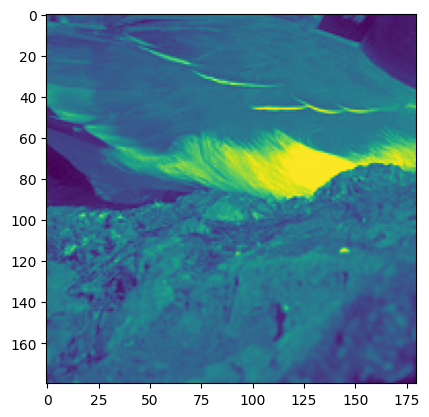

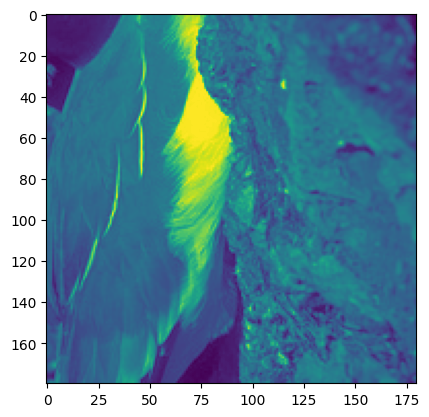

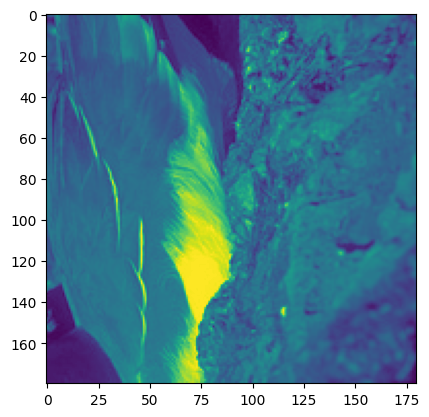

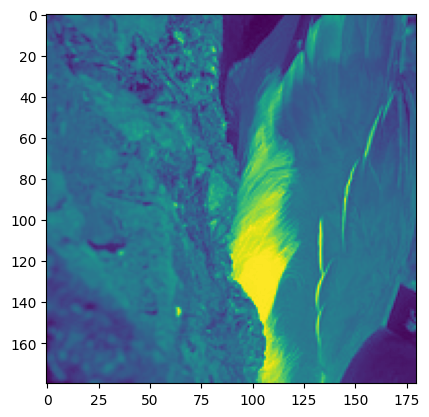

In [46]:
plt.figure()
plt.imshow(ex_img_bsd_500)
plt.show()


plt.figure()
plt.imshow(aaa.detach().cpu().squeeze().numpy())
plt.show()

plt.figure()
plt.imshow(bbb.detach().cpu().squeeze().numpy())
plt.show()

plt.figure()
plt.imshow(ccc.detach().cpu().squeeze().numpy())
plt.show()


In [29]:
v2.ToTensor(ex_img_bsd_500)

TypeError: __init__() takes 1 positional argument but 2 were given

In [39]:
ex_img_bsd_500/255

array([[0.38431373, 0.29411765, 0.22745098, ..., 0.17254902, 0.17647059,
        0.18039216],
       [0.43921569, 0.33333333, 0.25098039, ..., 0.17254902, 0.17647059,
        0.18431373],
       [0.49411765, 0.35686275, 0.23921569, ..., 0.17647059, 0.17647059,
        0.18039216],
       ...,
       [0.19215686, 0.25490196, 0.25882353, ..., 0.19215686, 0.18039216,
        0.14509804],
       [0.22745098, 0.30980392, 0.32941176, ..., 0.15686275, 0.14509804,
        0.12941176],
       [0.28235294, 0.35686275, 0.41176471, ..., 0.14117647, 0.1372549 ,
        0.12156863]])

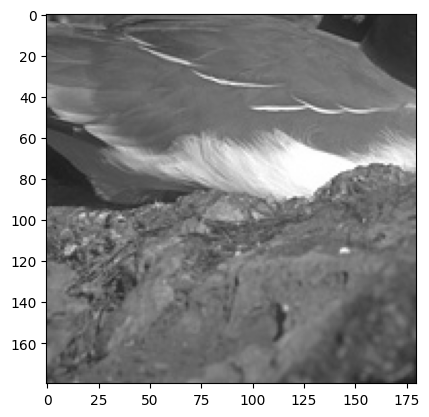

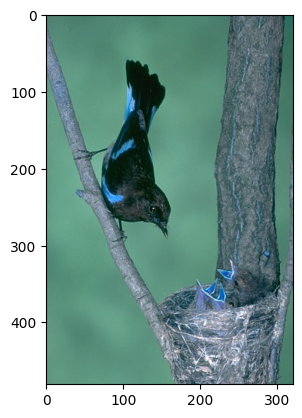

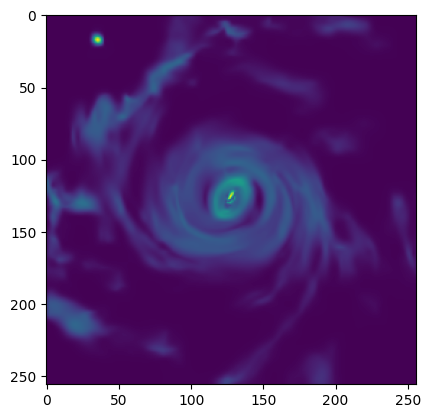

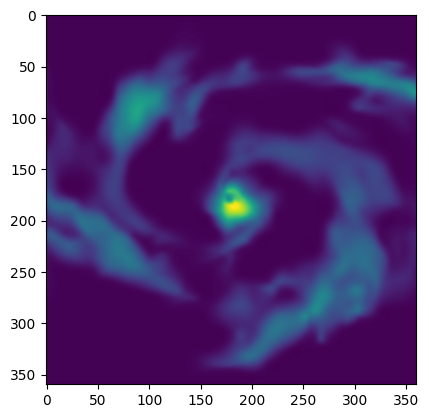

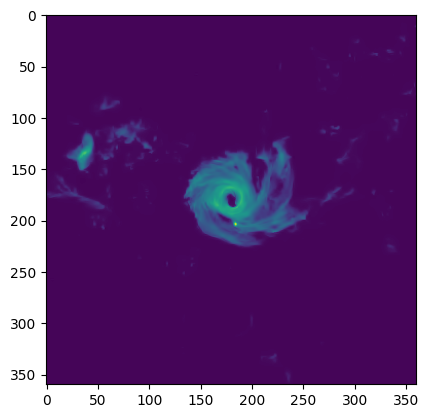

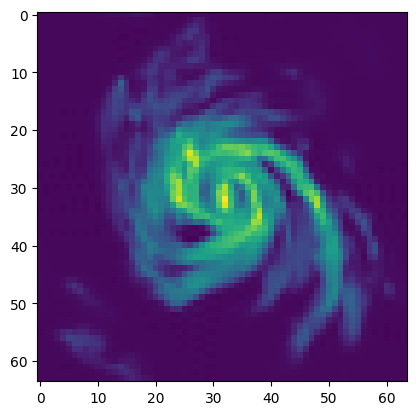

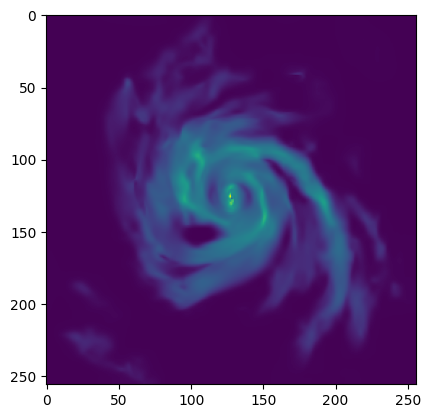

In [8]:
plt.figure()
plt.imshow(ex_img_bsd_500)
plt.show()


plt.figure()
plt.imshow(img_bsd_500)
plt.show()

plt.figure()
plt.imshow(gals_mat[2,:,:])
plt.show()

plt.figure()
plt.imshow(aa)
plt.show()

plt.figure()
plt.imshow(bb)
plt.show()

plt.figure()
plt.imshow(gal_64)
plt.show()

plt.figure()
plt.imshow(gal_256)
plt.show()